In [53]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import datetime as dt
from scipy.stats import pearsonr
# from rmse import rmse
import netCDF4 as nc
import re
from numpy import log, exp
import numpy as np
import sys
from datetime import datetime
# from lmfit import minimize, Parameters
# from PLUMBER2_VPD_common_utils import *
import pdb

# Calculate VPD via qair

In [54]:
def qair_to_vpd(qair, tair, press):
    '''
    calculate vpd
    Input: 
          qair: kg/kg
          tair: K
          press: Pa
    Output:
          vpd: kPa
    '''

    # set nan values
    qair = np.where(qair==-9999.,np.nan,qair)
    tair = np.where(tair==-9999.,np.nan,tair)
    press= np.where(press<-9999.,np.nan,press)

    DEG_2_KELVIN = 273.15
    PA_TO_KPA    = 0.001
    PA_TO_HPA    = 0.01

    # convert back to Pa
    # press        /= PA_TO_HPA
    tair         -= DEG_2_KELVIN

    # saturation vapor pressure
    es = 100.0 * 6.112 * np.exp((17.67 * tair) / (243.5 + tair))

    # vapor pressure
    ea = (qair * press) / (0.622 + (1.0 - 0.622) * qair)

    vpd = (es - ea) * PA_TO_KPA
    # vpd = np.where(vpd < 0.0, 0.0, vpd)

    return vpd

    

# Penman-Monteith Equation

In [55]:
# -*- coding: UTF-8 -*-

class PenmanMonteith(object):

    """
    Penman-Monteith equation to calculate canopy transpiration.

    - Class also contain a method to invert canopy conducance (gc) if
      transpiration is already known

    References:
    -----------
    * Monteith and Unsworth (1990) Principles of Environmental
      Physics, pg. 247. Although I have removed the soil heat flux as G'DAY
      calculates soil evaporation seperately.

    """

    def __init__(self, dz0v_dh=0.075, z0h_z0m=0.1, d=0.67, use_ustar=False):

        """
        Parameters:
        -----------
        cp : float
            specific heat of dry air [MJ kg-1 degC-1]
        vk : float
            von Karman's constant [unitless]
        epsilon : float
            ratio molecular weight of water vap/dry air
        zele_sea : float
            elevation above sea level [m]
        dz0v_dh : float
            rate change of roughness for momentum with height
        displace_ratio : float
            zero plain displacement height
        z0h_z0m : float
            Ratio of the roughness length for heat to the roughness length for
            momentum, see comment in method below!!!
        """

        self.CP = 1010.0                 # specific heat of dry air (j kg-1 k-1)
        self.VK = 0.41                   # von Karman constan
        self.J_TO_MJ = 1.0E-6
        self.C_TO_K = 273.15
        self.dz0v_dh = dz0v_dh
        self.displace_ratio = d          # zero plan displacement height
        self.z0h_z0m = z0h_z0m
        self.RGAS = 8.314                # J mol-1 K-1
        self.H2OLV0 = 2.501E6            # latent heat H2O (J kg-1)
        self.H2OMW = 18E-3               # mol mass H20 (kg mol-1)
        self.MASS_AIR = 29.0E-3          # mol mass air (kg mol-1)
        self.use_ustar = use_ustar       # calc ga using ustar

    def calc_evaporation(self, vpd, wind, rnet, tair, press, gs, canht=None,
                         ustar=None, G=None):
        """
        Parameters:
        -----------
        vpd : float
            vapour pressure def [Pa]
        wind : float
            average daytime wind speed [m s-1]
        rnet : float
            net radiation [W m-2]
        tair : float
            temperature [deg C]
        press : float
            average daytime pressure [Pa]
        gs : float
            stomatal conductance [mol m-2 s-1]
        canht : float
            canopy height [m]
        ustar : float
            friction velocity [m s-1]
        G : float
            soil heat flux [W m-2]

        Returns:
        --------
        trans : float
            transpiration [mol H20 m-2 s-1]
        """

        # use friction velocity
        if self.use_ustar:
            ga = self.calc_bdary_layer_conduc_from_ustar(wind, ustar, press,
                                                         tair)
        else:
            ga = self.canopy_bdary_layer_conduct(canht, wind, press, tair)
        lambdax = self.calc_latent_heat_of_vapourisation(tair)
        gamma = self.calc_pyschrometric_constant(lambdax, press)
        slope = self.calc_slope_of_sat_vapour_pressure_curve(tair)

        # Total leaf conductance to water vapour
        #gv = 1.0 / (1.0 / gs + 1.0 / ga)

        if G is None:
            G = 0.0 # ground heat flux

        arg1 = slope * (rnet - G) + ga * self.MASS_AIR * self.CP * vpd
        arg2 = slope + gamma * (1.0 + ga / gs)
        LE = arg1 / arg2 # W m-2

        # mol H20 m-2 s-1
        transpiration = LE / lambdax
        transpiration = np.where(transpiration < 0.0, 0.0, transpiration)

        return transpiration

    def invert_penman(self, vpd, wind, rnet, tair, press, trans, canht=None,
                      ustar=None, G=None):
        """
        Invert Penman-Monteith eqn to obtain canopy conductance

        Parameters:
        -----------
        vpd : float
            vapour pressure def [Pa]
        wind : float
            average daytime wind speed [m s-1]
        rnet : float
            net radiation [W m-2]
        tair : float
            temperature [degC]
        press : float
            average daytime pressure [Pa]
        trans : float
            transpiration [mol H20 m-2 s-1]
        canht : float
            canopy height [m]
        ustar : float
            friction velocity [m s-1]
        G : float
            soil heat flux [W m-2]

        Returns:
        --------
        gc : float
            canopy conductance [mol m-2 s-1]

        Reference:
        ---------
        * Landsberg and Sands, eqn 2.53
        """
        if self.use_ustar:
            ga = self.calc_bdary_layer_conduc_from_ustar(wind, ustar, press,
                                                         tair)
        else:
            ga = self.canopy_bdary_layer_conduct(canht, wind, press, tair)

        lambdax = self.calc_latent_heat_of_vapourisation(tair)
        gamma = self.calc_pyschrometric_constant(lambdax, press)
        slope = self.calc_slope_of_sat_vapour_pressure_curve(tair)
        lambda_E = trans * lambdax

        if G is None:
            G = 0.0 # ground heat flux

        arg1 = ga * gamma * lambda_E
        arg2 = slope * (rnet - G) - (slope + gamma) * lambda_E
        arg3 = ga * self.MASS_AIR * self.CP * vpd

        Gs = arg1 / (arg2 + arg3)
        Gs = np.where(Gs < 0.0001, 0.0001, Gs)
        
        # inger ecosystem-scale, VPD_l (Pa)
        VPDl = (gamma * lambda_E) / (self.MASS_AIR * self.CP * Gs)

        return Gs, VPDl, ga, gamma, slope, arg1, arg2, arg3

    def calc_decoupling_coefficent(self, wind, tair, press, gs, canht=None,
                                  ustar=None):
        """
        Calculate decoupling coefficient.
            - As omega -> 0, leaf surface becomes strongly coupled to the
              atmosphere.
            - As omega -> 1, leaf surfaces are poorly coupled to the
              atmosphere.

        Parameters:
        -----------
        wind : float
            average daytime wind speed [m s-1]
        tair : float
            temperature [degC]
        press : float
            average daytime pressure [Pa]
        gs : float
            stomatal conductance [mol H20 m-2 s-1]
        canht : float
            canopy height [m]
        ustar : float
            friction velocity [m s-1]

        Returns:
        --------
        omega : float
            decoupling coefficient (-)


        References:
        -----------
        * McNaughton and Jarvis 1986
        """
        if self.use_ustar:
            ga = self.calc_bdary_layer_conduc_from_ustar(wind, ustar, press,
                                                         tair)
        else:
            ga = self.canopy_bdary_layer_conduct(canht, wind, press, tair)

        # ga sensitivity test +/- 30%
        #ga = np.where(ga>0.0, ga*1.3, ga)
        #ga = np.where(ga>0.0, ga-(ga*0.3), ga)

        lambdax = self.calc_latent_heat_of_vapourisation(tair)
        gamma = self.calc_pyschrometric_constant(lambdax, press)
        slope = self.calc_slope_of_sat_vapour_pressure_curve(tair)

        epsilon = slope / gamma
        omega = (1.0 + epsilon) / (1.0 + epsilon + ga / gs)

        if len(gs) < 1:
            omega = np.ones(len(wind)) * -999.9
            ga = np.ones(len(wind)) * -999.9
            gs = np.ones(len(wind)) * -999.9
        elif np.nanmean(gs) < 0.0:
            omega = np.ones(len(wind)) * -999.9
            ga = np.ones(len(wind)) * -999.9
            gs = np.ones(len(wind)) * -999.9
        else:
            omega = (1.0 + epsilon) / (1.0 + epsilon + ga / gs)

        return (omega, ga, gs)

    def calc_bdary_layer_conduc_from_ustar(self, wind, ustar, press, tair):
        """
        Calculate boundary layer conductance using measured friction velocity,
        ustar

        Parameters:
        -----------
        wind : float
            average daytime wind speed [m s-1]
        ustar : float
            friction velocity [m s-1]

        Returns:
        --------
        ga : float
            canopy boundary layer conductance (mol m-2 s-1)

        References:
        ----------
        * Monteith & Unsworth p. 341 eqn. 17.8
        """

        # Convert from m s-1 to mol m-2 s-1
        # - note conversion in Jones '92 is mmol to mmol, but units cancel
        Tk = tair + self.C_TO_K
        cmolar = press / (self.RGAS * Tk)

        ga = 1.0 / (wind / ustar**2 + 6.2 * ustar**-0.667)
        ga *= cmolar

        #ga3 = ustar**2 / (wind + 6.2 * ustar**(4./3.))
        #ga3 *= cmolar

        return (ga)

    def canopy_bdary_layer_conduct(self, canht, wind, press, tair):
        """  Canopy boundary layer conductance, ga (from Jones 1992 p 68)

        Notes:
        ------
        'Estimates of ga for pine canopies from LAI of 3 to 6 vary from
        3.5 to 1.1 mol m-2 s-1  (Kelliher et al., 1993; Juang et al., 2007).'
        Drake et al, 2010, 17, pg. 1526.

        References:
        ------------
        * Jones 1992, pg. 67-8.
        * Monteith and Unsworth (1990), pg. 248. Note this in the inverted form
          of what is in Monteith (ga = 1 / ra)
        * Allen et al. (1989) pg. 651.
        * Gash et al. (1999) Ag forest met, 94, 149-158.

        Parameters:
        -----------
        wind : float
            average daytime wind speed [m s-1]
        press : float
            atmospheric pressure (Pa)
        tair : float
            air temperature (deg C)
        canht : float
            canopy height (m)

        Returns:
        --------
        ga : float
            canopy boundary layer conductance [mol m-2 s-1]
        """

        # Convert from m s-1 to mol m-2 s-1
        # - note conversion in Jones '92 is mmol to mmol, but units cancel
        Tk = tair + self.C_TO_K
        cmolar = press / (self.RGAS * Tk)

        # roughness length for momentum
        z0m = self.dz0v_dh * canht

        # z0h roughness length governing transfer of heat and vapour [m]
        # *Heat tranfer typically less efficent than momentum transfer. There is
        #  a lot of variability in values quoted for the ratio of these two...
        #  JULES uses 0.1, Campbell and Norman '98 say z0h = z0m / 5. Garratt
        #  and Hicks, 1973/ Stewart et al '94 say z0h = z0m / 7. Therefore for
        #  the default I am following Monteith and Unsworth, by setting the
        #  ratio to be 1, the code below is identical to that on page 249,
        #  eqn 15.7
        z0h = self.z0h_z0m * z0m

        # zero plan displacement height [m]
        d = self.displace_ratio * canht


        arg1 = self.VK**2 * wind
        arg2 = log((canht - d) / z0m)
        arg3 = log((canht - d) / z0h)

        ga = (arg1 / (arg2 * arg3)) * cmolar

        return (ga)

    def calc_slope_of_sat_vapour_pressure_curve(self, tair):
        """ Constant slope in Penman-Monteith equation

        Parameters:
        -----------
        tavg : float
            average daytime temperature

        Returns:
        --------
        slope : float
            slope of saturation vapour pressure curve [Pa K-1]
        """
        arg1 = self.calc_sat_water_vapour_press(tair+0.1)
        arg2 = self.calc_sat_water_vapour_press(tair)
        slope = (arg1 - arg2) / 0.1

        return (slope)

    def calc_sat_water_vapour_press(self, tac):
        """ Calculate saturated water vapour pressure at temperature TAC

        Parameters:
        -----------
        tac : float
            Celsius

        Returns:
        --------
        sat : float
            units: Pa

        References:
        -----------
        * Jones 1992 p 110 (note error in a - wrong units)
        """

        return (613.75 * exp(17.502 * tac / (240.97 + tac)));

    def calc_pyschrometric_constant(self, lambdax, press):
        """ Psychrometric constant ratio of specific heat of moist air at
        a constant pressure to latent heat of vaporisation.

        Parameters:
        -----------
        press : float
            air pressure (Pa)
        lambda : float
             latent heat of water vaporization (J mol-1)

        Returns:
        --------
        gamma : float
            pyschrometric constant [Pa K-1]
        """

        return (self.CP * self.MASS_AIR * press / lambdax)

    def calc_latent_heat_of_vapourisation(self, tair):
        """
        Latent heat of water vapour at air temperature

        Returns:
        -----------
        lambda : float
            latent heat of water vaporization [J mol-1]
        """

        return ((self.H2OLV0 - 2.365E3 * tair) * self.H2OMW)




# if __name__ == "__main__":

#     KPA_2_PA = 1000.0

#     # these numbers are entirely made up!
#     tair = 25.0
#     vpd = 1.5 * KPA_2_PA
#     wind = 1.5
#     rnet = 12.0 # W m-2
#     press = 101.325 * KPA_2_PA
#     gs = 0.14915878
#     canht = 12.0

#     # Coniferous forest, based on Jones 1976, from Jones '92, pg 67
#     P = PenmanMonteith(dz0v_dh=0.075, z0h_z0m=0.1)
#     trans = P.calc_evaporation(vpd, wind, rnet, tair, press, gs, canht)
#     # mmol m-2 s-1
#     print(trans * 1000.0)
#     print(gs)

#     gc = P.invert_penman(vpd, wind, rnet, tair, press, trans, canht)
#     print(gc)
#     print("\n")


# Constants

In [56]:
"""
A series of everyday constants, well.
"""
MOL_2_MMOL = 1000.0
M_2_MM = 1E03
MOL_WATER_2_G_WATER = 18.02
G_WATER_TO_MOL_WATER = 1.0 / MOL_WATER_2_G_WATER
MMOL_2_MOL = 1E-03
UMOL_2_JOL = 4.57          # conversion from J to umol quanta
MOL_C_TO_GRAMS_C = 12.
UMOL_TO_MOL = 0.000001
G_TO_KG = 1E-03
KG_TO_G = 1000.0
J_TO_MJ = 1.0E-6
SW_2_PAR = 2.3
PAR_2_SW = 1.0 / SW_2_PAR
SIGMA = 5.67E-8 # Stefan Boltzmann constant, J s-1 m-2 K-4
DEG_2_KELVIN = 273.15
PA_TO_KPA = 0.001
KPA_TO_PA = 1000.
HPA_TO_KPA = 0.1
SW_2_PAR = 2.3
RGAS = 8.314
GSVGSC = 1.57           # Ratio of Gsw:Gsc
H2OLV0 = 2.501E6        # latent heat H2O (J kg-1)
H2OMW = 18E-3           # mol mass H20 (kg mol-1)
CP = 1010.0             # specific heat of dry air (j kg-1 k-1)
AIR_MASS = 29.0E-3      # mol mass air (kg mol-1)
KPA_2_PA = 1000.
GSC_2_GSW = 1.57        # Ratio of Gsw:Gsc
GSW_2_GSC = 1.0 / GSC_2_GSW
GBH_2_GBW = 1.075
GBC_2_GBH = 1.32
GBH_2_GBC = 1.0 / GBC_2_GBH
SIGMA = 5.6704E-08        # Stefan-Boltzmann constant, (w m-2 k-4)
CP = 1010.0               # specific heat of dry air (j kg-1 k-1)
DHEAT = 21.5E-6           # molecular diffusivity for heat (m2 s-1)
RSPECIFC_DRY_AIR = 287.058 # Jkg-1 K-1
SEC_TO_HLFHR = 1800.0
SEC_TO_HR = 3600.0


In [57]:
def read_met_variables(PLUMBER2_met_path, site_name):

    '''
    Read met variable from PLUMBER2 met files: 'VPD', 'Tair', 'Precip', 'Wind', 'Psurf',
    Other variables may need: 'CO2air', 'CO2air_qc'
    '''

    file_path = glob.glob(PLUMBER2_met_path+site_name+"*.nc")
    # print('file_path1',file_path)
    f         = nc.Dataset(file_path[0])
    VPD       = np.squeeze(f.variables['VPD'][:])
    Tair      = np.squeeze(f.variables['Tair'][:])
    Qair      = np.squeeze(f.variables['Qair'][:])
    Precip    = np.squeeze(f.variables['Precip'][:])
    Wind      = np.squeeze(f.variables['Wind'][:])
    Psurf     = np.squeeze(f.variables['Psurf'][:])
    RH        = np.squeeze(f.variables['RH'][:])
    canht     = np.squeeze(f.variables['canopy_height'][:])

    return canht, VPD, Tair, Precip, Wind, Psurf, Qair, RH

def read_obs_flux_variables(PLUMBER2_flux_path, site_name, message):

    '''
    Read obs from PLUMBER2 flux files: 'Qle', 'Qh', 'GPP', 'Rnet', 'Qg'
    Other variables may need: 'Qle_cor', 'Qh_cor', 'Qg_qc', 'Qle_qc', 'Qh_qc',
                              'Qle_cor_uc', 'Qh_cor_uc',
    '''

    # Read model flux variables
    file_path = glob.glob(PLUMBER2_flux_path+site_name+"*.nc")
    # print('file_path2',file_path)
    f         = nc.Dataset(file_path[0])

    try:
        Qle   = np.squeeze(f.variables['Qle'][:])
    except:
        Qle   = np.nan
        message = '         Obs Qle not exist.\n'

    try:
        Qh    = np.squeeze(f.variables['Qh'][:])
    except:
        Qh    = np.nan
        message = '         Obs Qh not exist.\n'

    try:
        GPP   = np.squeeze(f.variables['GPP'][:])
    except:
        GPP   = np.nan
        message = '         Obs GPP not exist.\n'

    try:
        Rnet  = np.squeeze(f.variables['Rnet'][:])
    except:
        Rnet  = np.nan
        message = '         Obs Rnet not exist.\n'

    try:
        Qg    = np.squeeze(f.variables['Qg'][:])
    except:
        Qg    = np.nan
        # message = '         Obs Qg not exist.\n'

    try:
        Ustar = np.squeeze(f.variables['Ustar'][:])
    except:
        Ustar = np.nan
        message = '         Obs Ustar not exist.\n'

    return Qle, Qh, GPP, Rnet, Qg, Ustar, message

def read_model_flux_variables(file_path, Qle_name=None, Qh_name=None, Qg_name=None, Rnet_name=None, GPP_name=None):

    '''
    Read obs from model files: 'Qle', 'Qh', 'GPP', 'Rnet', Qg'
    models with Qg: ACASA, CABLE, CABLE-POP-CN, MuSICA, ORC2_r6593, ORC2_r6593_CO2, STEMMUS-SCOPE
    '''

    try:
        f         = nc.Dataset(file_path[0])
        if not ('None' in Qle_name):
            Qle_model = np.squeeze(f.variables[Qle_name][:])
        else:
            Qle_model = np.nan

        if not ('None' in Qh_name):
            Qh_model  = np.squeeze(f.variables[Qh_name][:])
        else:
            Qh_model  = np.nan

        if not ('None' in Qg_name):
            Qg_model  = np.squeeze(f.variables[Qg_name][:])
        else:
            Qg_model  = np.nan

        if not ('None' in GPP_name):
            GPP_model = np.squeeze(f.variables[GPP_name][:])
        else:
            GPP_model = np.nan

        print('Rnet_name',Rnet_name)
        if ('None' in Rnet_name):
            Rnet_model = np.nan
        elif len(Rnet_name) == 2:
            Rnet_model = np.squeeze(f.variables[Rnet_name[0]][:]+f.variables[Rnet_name[1]][:])
        else:
            Rnet_model = np.squeeze(f.variables[Rnet_name][:])

    except:
        Qle_model, Qh_model, GPP_model, Rnet_model, Qg_model = np.nan, np.nan, np.nan, np.nan, np.nan

    return Qle_model, Qh_model, GPP_model, Rnet_model, Qg_model

def latent_heat_vapourisation(tair):
    """
    Latent heat of vapourisation is approximated by a linear func of air
    temp (J kg-1)

    Reference:
    
    ----------
    * Stull, B., 1988: An Introduction to Boundary Layer Meteorology
      Boundary Conditions, pg 279.
    """
    return (2.501 - 0.00237 * tair) * 1E06


def gs_model_lohammar(VPD, m, gs_ref):
    return -m * np.log(VPD) + gs_ref

def residual(params, VPD, obs):
    m = params['m'].value
    gs_ref = params['gs_ref'].value
    model = gs_model_lohammar(VPD, m, gs_ref)

    return (obs - model)

In [58]:

# Path of PLUMBER 2 dataset
PLUMBER2_path      = "/g/data/w97/mm3972/data/PLUMBER2/"
PLUMBER2_script    = "/g/data/w97/mm3972/scripts/PLUMBER2/LSM_VPD_PLUMBER2/"
PLUMBER2_flux_path = "/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Flux/"
PLUMBER2_met_path  = "/g/data/w97/mm3972/data/Fluxnet_data/Post-processed_PLUMBER2_outputs/Nc_files/Met/"

# site_names, IGBP_types, clim_types, model_names_list = load_default_list()

# The site names
# model_names        = model_names_list['model_select']

site_name = 'AU-Tum'
model_name= 'CABLE'


Qle_dict = {'CABLE':'Qle'}
Qh_dict  = {'CABLE':'Qh'}
Qg_dict  = {'CABLE':'Qg'}
GPP_dict = {'CABLE':'GPP'}
Rnet_dict= {'CABLE':'Rnet'}

# calc_gs_one_site(PLUMBER2_met_path, PLUMBER2_flux_path, site_name, model_names,
#                  Qle_dict, Qh_dict, Qg_dict, Rnet_dict, GPP_dict)
    # pdb.set_trace()


## calc_gs_one_site

In [59]:
# ================== Reading data ==================
# Read obs met data

message = 'Site '+site_name+'\n'
canht, VPD_obs, Tair_obs, Precip_obs, Wind_obs, Psurf_obs, Qair_obs,RH_obs = \
    read_met_variables(PLUMBER2_met_path, site_name)


# Read obs flux data
Qle_obs, Qh_obs, GPP_obs, Rnet_obs, Qg_obs, Ustar_obs, message = \
    read_obs_flux_variables(PLUMBER2_flux_path, site_name, message)



In [60]:

message = 'Model '+model_name+'\n'

# Give values to var_input
var_input           = pd.DataFrame(VPD_obs/10., columns=['VPD']) # hPa=>kPa
var_input['Tair']   = Tair_obs # K
var_input['Qair']   = Qair_obs # kg/kg
var_input['Precip'] = Precip_obs # kg/m2/s
var_input['Wind']   = Wind_obs # m/s
var_input['Psurf']  = Psurf_obs # Pa
var_input['Qle']    = Qle_obs # W/m2
var_input['Qh']     = Qh_obs # W/m2
var_input['Qg']     = Qg_obs # W/m2
var_input['GPP']    = GPP_obs # umol/m2/s
var_input['Rnet']   = Rnet_obs # W/m2
var_input['Ustar']  = Ustar_obs # m/s
var_input['RH']     = RH_obs # m/s


In [61]:
var_input['VPD_cal']= qair_to_vpd(var_input['Qair'],var_input['Tair'],var_input['Psurf'])
var_input[:20]

,VPD,Tair,Qair,Precip,Wind,Psurf,Qle,Qh,Qg,GPP,Rnet,Ustar,RH,VPD_cal
0,0.087452,282.920013,0.008117,0.0,3.855441,85925.0,3.627000,-34.954899,-7.070,0.000000,-65.580002,0.4432,92.765228,0.092548
1,0.057176,282.739990,0.008239,0.0,4.103464,85850.0,11.542800,-25.485201,-8.200,0.000000,-48.820000,0.5236,95.212341,0.062447
2,0.036722,282.390015,0.008190,0.0,2.540000,85800.0,-2.429100,-4.428600,-8.365,0.000000,-36.439999,0.2208,96.851730,0.041960
3,0.000000,281.040009,0.007852,0.0,2.450000,85875.0,-6.231800,-3.902600,-7.960,0.000000,-49.480000,0.1768,100.000000,-0.014687
4,0.000000,279.799988,0.007571,0.0,2.020000,85900.0,-11.119500,-1.727300,-8.360,0.000000,-54.860001,0.0935,100.000000,-0.063077
5,0.000000,279.980011,0.007413,0.0,2.700000,85900.0,18.663200,13.289800,-8.735,-0.639665,6.290000,0.4025,100.000000,-0.029358
6,0.000000,280.529999,0.007646,0.0,3.760000,85950.0,59.282799,46.836498,-6.885,11.391329,107.220001,0.6989,100.000000,-0.023809
7,0.000000,280.850006,0.007621,0.0,4.650000,86000.0,103.722000,172.168594,-4.030,21.973757,327.320007,0.9586,100.000000,0.001753
8,0.015512,280.899994,0.007513,0.0,4.060000,86000.0,112.474602,158.183304,0.030,12.861961,344.579987,0.8677,98.528679,0.020030
9,0.036190,281.730011,0.007807,0.0,5.060000,86000.0,148.059402,234.163803,4.105,20.232933,493.209991,1.0993,96.755783,0.040997


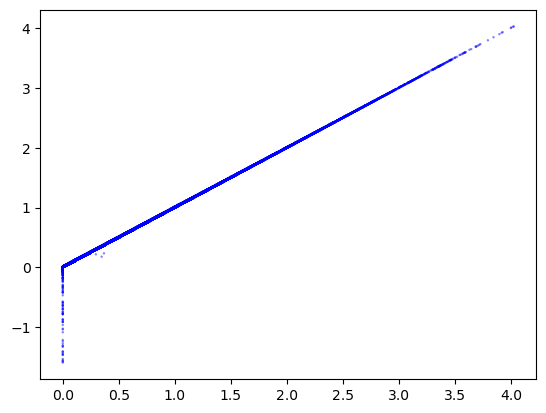

In [62]:
plt.scatter(var_input['VPD'],var_input['VPD_cal'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
# plt.plot(np.arange(0,7),np.arange(0,7),c='black')

In [63]:
file_path = glob.glob(PLUMBER2_path+model_name +"/*"+site_name+"*.nc")

# Get model fluxes
Qle_model, Qh_model, GPP_model, Rnet_model, Qg_model = \
        read_model_flux_variables(file_path, Qle_dict[model_name],
                                Qh_dict[model_name], Qg_dict[model_name],
                                Rnet_dict[model_name], GPP_dict[model_name])



Rnet_name Rnet


In [64]:

# Check the time interval
ntime_obs   = len(Qle_obs)
ntime_model = len(Qle_model)

# Give values to var_input
if ntime_model == ntime_obs:
    # if half-hourly as observation
    if np.any(~np.isnan(Qle_model)):
        var_input['Qle'] = Qle_model
    else:
        message = message+'         '+model_name+' Qle not exist.\n'

    if np.any(~np.isnan(Qh_model)):
        var_input['Qh']  = Qh_model
    else:
        message = message+'         '+model_name+' Qh not exist.\n'

    if np.any(~np.isnan(Qg_model)):
        var_input['Qg']  = Qg_model
    # else:
    #     message = message+'         '+model_name+' Qg not exist.\n'

    if np.any(~np.isnan(Rnet_model)):
        var_input['Rnet']= Rnet_model
    else:
        message = message+'         '+model_name+' Rnet not exist.\n'

    if np.any(~np.isnan(GPP_model)):
        var_input['GPP'] = GPP_model
    else:
        message = message+'         '+model_name+' GPP not exist.\n'

elif ntime_model == int(ntime_obs/2):
    # if it is hourly
    print('model ', model_name, ' is hourly, model_ntime is', ntime_model, ' ntime_obs is', ntime_obs)

    # put the value of hourly data to the first half hour
    if np.any(~np.isnan(Qle_model)):
        var_input['Qle'][::2]  = Qle_model
        var_input['Qle'][1::2] = Qle_model
    else:
        message = message+'         '+model_name+' Qle not exist.\n'

    if np.any(~np.isnan(Qh_model)):
        var_input['Qh'][::2]  = Qh_model
        var_input['Qh'][1::2] = Qh_model
    else:
        message = message+'         '+model_name+' Qh not exist.\n'

    if np.any(~np.isnan(Qg_model)):
        var_input['Qg'][::2]  = Qg_model
        var_input['Qg'][1::2] = Qg_model
    # else:
    #     message = message+'         '+model_name+' Qg not exist.\n'

    if np.any(~np.isnan(Rnet_model)):
        var_input['Rnet'][::2]  = Rnet_model
        var_input['Rnet'][1::2] = Rnet_model
    else:
        message = message+'         '+model_name+' Rnet not exist.\n'

    if np.any(~np.isnan(GPP_model)):
        var_input['GPP'][::2]  = GPP_model
        var_input['GPP'][1::2] = GPP_model
    else:
        message = message+'         '+model_name+' GPP not exist.\n'

else:
    # if it is hourly
    print('Error occur! ntime_model is ', ntime_model, 'ntime_obs is', ntime_obs)
    
var_input[:10]

,VPD,Tair,Qair,Precip,Wind,Psurf,Qle,Qh,Qg,GPP,Rnet,Ustar,RH,VPD_cal
0,0.087452,282.920013,0.008117,0.0,3.855441,85925.0,6.075706,-34.418823,-53.329746,0.000000,-81.673058,0.4432,92.765228,0.092548
1,0.057176,282.739990,0.008239,0.0,4.103464,85850.0,4.781828,-37.075161,-46.927826,0.000000,-79.221367,0.5236,95.212341,0.062447
2,0.036722,282.390015,0.008190,0.0,2.540000,85800.0,2.937746,-36.211658,-43.196018,0.000000,-76.469955,0.2208,96.851730,0.041960
3,0.000000,281.040009,0.007852,0.0,2.450000,85875.0,2.844429,-31.144718,-46.066021,0.000000,-74.366150,0.1768,100.000000,-0.014687
4,0.000000,279.799988,0.007571,0.0,2.020000,85900.0,2.316629,-26.422579,-47.509335,0.000000,-71.615349,0.0935,100.000000,-0.063077
5,0.000000,279.980011,0.007413,0.0,2.700000,85900.0,-4.172948,-12.559088,-35.435802,2.387836,-52.167908,0.4025,100.000000,-0.029358
6,0.000000,280.529999,0.007646,0.0,3.760000,85950.0,14.696678,45.133320,-6.776185,9.978786,53.053871,0.6989,100.000000,-0.023809
7,0.000000,280.850006,0.007621,0.0,4.650000,86000.0,76.964172,202.006042,38.279675,20.534252,317.250122,0.9586,100.000000,0.001753
8,0.015512,280.899994,0.007513,0.0,4.060000,86000.0,85.590385,212.972137,13.924338,20.776005,312.486572,0.8677,98.528679,0.020030
9,0.036190,281.730011,0.007807,0.0,5.060000,86000.0,123.238724,286.236938,40.684837,25.543409,450.160339,1.0993,96.755783,0.040997


In [65]:

# ================== Prepare data ==================

# Convert units ...
var_input['Tair'] -= 273.15

# screen for dew
var_input['Qle'] = np.where( var_input['Qle'] > 0.0, var_input['Qle'], np.nan)

# Calculate ET, W m-2 to kg m-2 s-1
lhv              = latent_heat_vapourisation(var_input['Tair'])
var_input['ET']  = var_input['Qle'] / lhv

# kg m-2 s-1 to mol m-2 s-1
conv            = KG_TO_G * G_WATER_TO_MOL_WATER
var_input['ET']*= conv

# screen highly saturated conditions
# var_input['VPD']= np.where(var_input['VPD']> 0.05, var_input['VPD'], np.nan)
# MMY: VPD units is kPa

# kPa to Pa
var_input['VPD']= var_input['VPD']*1000.

var_input[:10]

,VPD,Tair,Qair,Precip,Wind,Psurf,Qle,Qh,Qg,GPP,Rnet,Ustar,RH,VPD_cal,ET
0,87.451668,9.770020,0.008117,0.0,3.855441,85925.0,6.075706,-34.418823,-53.329746,0.000000,-81.673058,0.4432,92.765228,0.092548,0.000136
1,57.176033,9.589996,0.008239,0.0,4.103464,85850.0,4.781828,-37.075161,-46.927826,0.000000,-79.221367,0.5236,95.212341,0.062447,0.000107
2,36.722214,9.240021,0.008190,0.0,2.540000,85800.0,2.937746,-36.211658,-43.196018,0.000000,-76.469955,0.2208,96.851730,0.041960,0.000066
3,0.000000,7.890015,0.007852,0.0,2.450000,85875.0,2.844429,-31.144718,-46.066021,0.000000,-74.366150,0.1768,100.000000,-0.014687,0.000064
4,0.000000,6.649994,0.007571,0.0,2.020000,85900.0,2.316629,-26.422579,-47.509335,0.000000,-71.615349,0.0935,100.000000,-0.063077,0.000052
5,0.000000,6.830017,0.007413,0.0,2.700000,85900.0,NaN,-12.559088,-35.435802,2.387836,-52.167908,0.4025,100.000000,-0.029358,NaN
6,0.000000,7.380005,0.007646,0.0,3.760000,85950.0,14.696678,45.133320,-6.776185,9.978786,53.053871,0.6989,100.000000,-0.023809,0.000328
7,0.000000,7.700012,0.007621,0.0,4.650000,86000.0,76.964172,202.006042,38.279675,20.534252,317.250122,0.9586,100.000000,0.001753,0.001720
8,15.512089,7.750000,0.007513,0.0,4.060000,86000.0,85.590385,212.972137,13.924338,20.776005,312.486572,0.8677,98.528679,0.020030,0.001913
9,36.189999,8.580017,0.007807,0.0,5.060000,86000.0,123.238724,286.236938,40.684837,25.543409,450.160339,1.0993,96.755783,0.040997,0.002757


In [66]:

# (var_input, no_G) = filter_dataframe(var_input, hour) # MMY: hour tells it is hourly or half-hour data
# if no_G:
#     G = None
# print(var_input)

# print("np.sum(var_input['GPP'])",np.sum(var_input['GPP']))
# print('Before len(var_input)',len(var_input))
# To avoid crash in Gs calculation, set the row with any missing value in a column as np.nan
subset            = ['VPD', 'Rnet', 'Wind', 'Tair', 'Psurf', 'ET']
var_input[subset] = var_input[subset].where(~var_input[subset].isna().any(axis=1), other=np.nan)
# print('After len(var_input)',len(var_input))


In [67]:
var_input[:10]

,VPD,Tair,Qair,Precip,Wind,Psurf,Qle,Qh,Qg,GPP,Rnet,Ustar,RH,VPD_cal,ET
0,87.451668,9.770020,0.008117,0.0,3.855441,85925.0,6.075706,-34.418823,-53.329746,0.000000,-81.673058,0.4432,92.765228,0.092548,0.000136
1,57.176033,9.589996,0.008239,0.0,4.103464,85850.0,4.781828,-37.075161,-46.927826,0.000000,-79.221367,0.5236,95.212341,0.062447,0.000107
2,36.722214,9.240021,0.008190,0.0,2.540000,85800.0,2.937746,-36.211658,-43.196018,0.000000,-76.469955,0.2208,96.851730,0.041960,0.000066
3,0.000000,7.890015,0.007852,0.0,2.450000,85875.0,2.844429,-31.144718,-46.066021,0.000000,-74.366150,0.1768,100.000000,-0.014687,0.000064
4,0.000000,6.649994,0.007571,0.0,2.020000,85900.0,2.316629,-26.422579,-47.509335,0.000000,-71.615349,0.0935,100.000000,-0.063077,0.000052
5,NaN,NaN,0.007413,0.0,NaN,NaN,NaN,-12.559088,-35.435802,2.387836,NaN,0.4025,100.000000,-0.029358,NaN
6,0.000000,7.380005,0.007646,0.0,3.760000,85950.0,14.696678,45.133320,-6.776185,9.978786,53.053871,0.6989,100.000000,-0.023809,0.000328
7,0.000000,7.700012,0.007621,0.0,4.650000,86000.0,76.964172,202.006042,38.279675,20.534252,317.250122,0.9586,100.000000,0.001753,0.001720
8,15.512089,7.750000,0.007513,0.0,4.060000,86000.0,85.590385,212.972137,13.924338,20.776005,312.486572,0.8677,98.528679,0.020030,0.001913
9,36.189999,8.580017,0.007807,0.0,5.060000,86000.0,123.238724,286.236938,40.684837,25.543409,450.160339,1.0993,96.755783,0.040997,0.002757


In [68]:

# ==================
"""
PM = PenmanMonteith(use_ustar=False)
# Height from Wilkinson, M., Eaton, E. L., Broadmeadow, M. S. J., and
# Morison, J. I. L.: Inter-annual variation of carbon uptake by a
# plantation oak woodland in south-eastern England, Biogeosciences, 9,
# 5373–5389, https://doi.org/10.5194/bg-9-5373-2012, 2012.
(var_input['Gs'],
var_input['VPDl'])  = PM.invert_penman(var_input['VPD'].values, var_input['Wind'].values,
                                var_input['Rnet'].values, var_input['Tair'].values,
                                var_input['Psurf'].values,
                                var_input['ET'].values, canht=28., G=G)
"""

G = None
if np.all(~np.isnan(var_input['Ustar'])):
    PM = PenmanMonteith(use_ustar=True)
    (var_input['Gs_Qg'],
     var_input['VPDl_Qg'],
     var_input['ga'],
     var_input['gamma'],
     var_input['slope'],
     var_input['arg1'],
     var_input['arg2'],
     var_input['arg3'],)  = PM.invert_penman(var_input['VPD'].values, var_input['Wind'].values,
                                     var_input['Rnet'].values, var_input['Tair'].values,
                                     var_input['Psurf'].values,
                                     var_input['ET'].values,
                                     ustar=var_input["Ustar"], G=var_input['Qg'])
else:
    PM = PenmanMonteith(use_ustar=False)
    (var_input['Gs_Qg'],
     var_input['VPDl_Qg'],
     var_input['ga'],
     var_input['gamma'],
     var_input['slope'],
     var_input['arg1'],
     var_input['arg2'],
     var_input['arg3'],)  = PM.invert_penman(var_input['VPD'].values, var_input['Wind'].values,
                                var_input['Rnet'].values, var_input['Tair'].values,
                                var_input['Psurf'].values,
                                var_input['ET'].values, canht=canht, G=var_input['Qg'])

    
G = None
if np.all(~np.isnan(var_input['Ustar'])):
    PM = PenmanMonteith(use_ustar=True)
    (var_input['Gs_Qg'],
     var_input['VPDl_Qg'],
     var_input['ga'],
     var_input['gamma'],
     var_input['slope'],
     var_input['arg1'],
     var_input['arg2'],
     var_input['arg3'],)  = PM.invert_penman(var_input['VPD'].values, var_input['Wind'].values,
                                     var_input['Rnet'].values, var_input['Tair'].values,
                                     var_input['Psurf'].values,
                                     var_input['ET'].values,
                                     ustar=var_input["Ustar"], G=G)
else:
    PM = PenmanMonteith(use_ustar=False)
    (var_input['Gs_Qg'],
     var_input['VPDl_Qg'],
     var_input['ga'],
     var_input['gamma'],
     var_input['slope'],
     var_input['arg1'],
     var_input['arg2'],
     var_input['arg3'],) = PM.invert_penman(var_input['VPD'].values, var_input['Wind'].values,
                                var_input['Rnet'].values, var_input['Tair'].values,
                                var_input['Psurf'].values,
                                var_input['ET'].values, canht=canht, G=G)

# screen for bad inverted data
# MMY, I will filter these data in process_step1 so comment out them here
# mask_Gs               = (var_input['Gs'] <= 0.0) | (var_input['Gs'] > 4.5) | (np.isnan(var_input['Gs']))
# var_input[mask_Gs]    = np.nan
# mask_VPDl             = (var_input['VPDl'] <= 0.05 * 1000.) | (var_input['VPDl'] > 7.* 1000) | (np.isnan(var_input['VPDl']))
# var_input[mask_VPDl]  = np.nan

# VPDa = var_input['VPD'] * PA_TO_KPA
# VPDl = var_input['VPDl'] * PA_TO_KPA

# plot_VPD(VPDa, VPDl, site_name)
# plot_gs_vs_D(var_input['Gs'], VPDa, var_input['ET'], site_name)
# plot_LE_vs_Tair(var_input['LE'], var_input['Tair'], site_name)

# When parameterizing the model of Eq. 1 in the main text, we
# limited the data to those collected when VPD > 1.0 kPa. From Novick sup
# remove stable conditions
#var_input = var_input[(var_input.VPD/1000. >= 1.) & (var_input.Wind >= 1.)]

# gs_ref = np.mean(var_input[(var_input['VPD'] * PA_TO_KPA > 0.9) & \
#                     (var_input['VPD'] * PA_TO_KPA < 1.1)]['Gs'])

# params = Parameters()
# params.add('m', value=0.5)
# params.add('gs_ref', value=gs_ref, vary=False)

# result = minimize(residual, params, args=(var_input['VPD']*PA_TO_KPA, var_input['Gs']))
# for name, par in result.params.items():
#     print('%s = %.4f +/- %.4f ' % (name, par.value, par.stderr))

# m_pred = result.params['m'].value

#plt.plot(np.log(var_input['VPD']*PA_TO_KPA), var_input['Gs'], "ro")
#plt.plot(np.log(var_input['VPD']*PA_TO_KPA),
#         np.log(var_input['VPD']*PA_TO_KPA) * m_pred + gs_ref, "k-")
#plt.show()

# print(var_input)
# with open(f'{PLUMBER2_script}txt/process1_output/Gs/Message_gs_{site_name}_{model_name}.txt', 'w') as f:
#     f.write(message)
# var_input.to_csv(f'{PLUMBER2_script}txt/process1_output/Gs/Gs_{site_name}_{model_name}.csv') # , mode='a', index=False
# var_input = None
# message   = None

In [69]:
gvar_input[:20]

,VPD,Tair,Qair,Precip,Wind,Psurf,Qle,Qh,Qg,GPP,...,VPD_cal,ET,Gs_Qg,VPDl_Qg,ga,gamma,slope,arg1,arg2,arg3
0,87.451668,9.770020,0.008117,0.0,3.855441,85925.0,6.075706,-34.418823,-53.329746,0.000000,...,0.092548,0.000136,0.000100,116919.617188,1.205736,56.426579,81.668701,412.913269,-7508.244141,3088.442871
1,57.176033,9.589996,0.008239,0.0,4.103464,85850.0,4.781828,-37.075161,-46.927826,0.000000,...,0.062447,0.000107,0.000100,91924.343750,1.489833,56.367638,80.802002,401.132050,-7056.451660,2495.001465
2,36.722214,9.240021,0.008190,0.0,2.540000,85800.0,2.937746,-36.211658,-43.196018,0.000000,...,0.041960,0.000066,0.000100,56422.523438,0.529024,56.316006,79.144287,87.427391,-6449.673828,569.015198
3,0.000000,7.890015,0.007852,0.0,2.450000,85875.0,2.844429,-31.144718,-46.066021,0.000000,...,-0.014687,0.000064,0.000100,54607.550781,0.374749,56.292740,73.016357,59.939388,-5797.353516,0.000000
4,0.000000,6.649994,0.007571,0.0,2.020000,85900.0,2.316629,-26.422579,-47.509335,0.000000,...,-0.063077,0.000052,0.000100,44435.152344,0.141381,56.242680,67.752075,18.400852,-5139.023438,0.000000
5,NaN,NaN,0.007413,0.0,NaN,NaN,NaN,-12.559088,-35.435802,2.387836,...,-0.029358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000000,7.380005,0.007646,0.0,3.760000,85950.0,14.696678,45.133320,-6.776185,9.978786,...,-0.023809,0.000328,1.034984,27.271605,2.366664,56.314533,70.809326,1956.592651,1890.456299,0.000000
7,0.000000,7.700012,0.007621,0.0,4.650000,86000.0,76.964172,202.006042,38.279675,20.534252,...,0.001753,0.001720,1.071857,138.026443,3.220155,56.364468,72.187500,13953.887695,13018.425781,0.000000
8,15.512089,7.750000,0.007513,0.0,4.060000,86000.0,85.590385,212.972137,13.924338,20.776005,...,0.020030,0.001913,1.119405,146.983658,3.016427,56.367153,72.403564,14536.788086,11615.666992,1370.510864
9,36.189999,8.580017,0.007807,0.0,5.060000,86000.0,123.238724,286.236938,40.684837,25.543409,...,0.040997,0.002757,1.166965,203.172546,3.668761,56.411758,76.097412,25477.775391,17943.615234,3888.905273


In [70]:
# var_input['Gs'][:] = np.where(var_input['Gs'][:]<10,var_input['Gs'][:],np.nan)
# var_input['Gs_Qg'][:] = np.where(var_input['Gs_Qg'][:]<10,var_input['Gs_Qg'][:],np.nan)

# for i in np.arange(len(var_input)):
#     if var_input['Gs'][i] > 5:
#         print(i)
# #         print(var_input.iloc[i])

# for i in np.arange(len(var_input)):
#     if var_input['Gs_Qg'][i] > 5:
#         print(i)
#         print(var_input.iloc[i])


for i in np.arange(len(var_input)):
    if var_input['Gs_Qg'][i] > 10:
        print(i)
        print(var_input.iloc[i])

1995
VPD          672.174194
Tair          14.330017
Qair           0.006843
Precip         0.000000
Wind           2.200000
Psurf      87300.000000
Qle            1.132358
Qh           -67.809563
Qg           -23.007986
GPP            0.000000
Rnet         -89.685356
Ustar          0.198700
RH            58.828686
VPD_cal        0.675407
ET             0.000025
Gs_Qg        155.406631
VPDl_Qg        0.014309
ga             0.493991
gamma         57.580139
slope        106.372070
arg1          32.174030
arg2       -9725.468750
arg3        9725.675781
Name: 1995, dtype: float32
2389
VPD          105.750526
Tair          12.300018
Qair           0.009382
Precip         0.000000
Wind           1.830000
Psurf      87800.000000
Qle           21.353924
Qh             1.454904
Qg            -1.831039
GPP            6.045884
Rnet          20.977839
Ustar          0.164391
RH            92.605286
VPD_cal        0.112624
ET             0.000479
Gs_Qg         17.104933
VPDl_Qg        2.460787
ga 

In [71]:
plt.scatter(var_input['Gs'],var_input['Gs_Qg'], s=0.5, facecolors='none', edgecolors='blue',  alpha=0.5, label='data points')
plt.plot(np.arange(0,3),np.arange(0,3),c='black')

KeyError: 'Gs'

In [ ]:

# def plot_gs_vs_D(Gs, VPDa, ET, site_name):

#     fig = plt.figure(figsize=(9,6))
#     fig.subplots_adjust(hspace=0.1)
#     fig.subplots_adjust(wspace=0.05)
#     plt.rcParams['text.usetex'] = False
#     plt.rcParams['font.family'] = "sans-serif"
#     plt.rcParams['font.sans-serif'] = "Helvetica"
#     plt.rcParams['axes.labelsize'] = 14
#     plt.rcParams['font.size'] = 14
#     plt.rcParams['legend.fontsize'] = 14
#     plt.rcParams['xtick.labelsize'] = 14
#     plt.rcParams['ytick.labelsize'] = 14

#     ax = fig.add_subplot(111)
#     #ax.set_aspect('equal', adjustable='box')

#     ln1 = ax.plot(VPDa, Gs, marker="o", ls=" ", color="royalblue", alpha=0.3,
#                   label="G$_{s}$", markersize=7,
#                   markeredgecolor="None")

#     ax2 = ax.twinx()
#     ax2.set_ylabel("Evapotranspiration (mmol m$^{-2}$ s$^{-1}$)")
#     ln2 = ax2.plot(VPDa, ET*1000, "go", alpha=0.3, label="ET",
#                    markersize=7, markeredgecolor="None")

#     # added these three lines
#     lns = ln1+ln2
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs, numpoints=1, loc="best")


#     ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
#     ax.patch.set_visible(False)  # prevents ax1 from hiding ax2

#     #ax.set_ylim(0, 6)
#     #ax.set_xlim(0, 6)
#     ax.set_xlabel("VPD (kPa)")
#     ax.set_ylabel("Ecosystem conductance (mol m$^{-2}$ s$^{-1}$)")


#     odir = "plots"
#     ofname = "%s_gs_vs_VPD_2022.pdf" % (site_name)
#     fig.savefig(os.path.join(odir, ofname),
#                 bbox_inches='tight', pad_inches=0.1)

# def plot_VPD(VPDa, VPDl, site_name):

#     fig = plt.figure(figsize=(9,6))
#     fig.subplots_adjust(hspace=0.1)
#     fig.subplots_adjust(wspace=0.05)
#     plt.rcParams['text.usetex'] = False
#     plt.rcParams['font.family'] = "sans-serif"
#     plt.rcParams['font.sans-serif'] = "Helvetica"
#     plt.rcParams['axes.labelsize'] = 14
#     plt.rcParams['font.size'] = 14
#     plt.rcParams['legend.fontsize'] = 14
#     plt.rcParams['xtick.labelsize'] = 14
#     plt.rcParams['ytick.labelsize'] = 14

#     ax = fig.add_subplot(111)
#     ax.set_aspect('equal', adjustable='box')

#     ax.plot(VPDa, VPDl, "k.", alpha=0.5)

#     one2one = np.array([0, 350])
#     ax.plot(one2one, one2one, ls='--', color="grey", label="1:1 line")

#     r, pval = pearsonr(VPDa, VPDl)
#     print(r, pval)
#     #if pval <= 0.05:
#     m,c = np.polyfit(VPDa, VPDl, 1)
#     ax.plot(VPDa, VPDa*m+c, ls="-", c="red")


#     ax.set_ylim(0, 6)
#     ax.set_xlim(0, 6)
#     ax.set_xlabel("VPD$_a$ (kPa)")
#     ax.set_ylabel("VPD$_l$ (kPa)")

#     ax.text(3.5, 0.5, 'R$^{2}$ = %0.2f' % r**2)
#     ax.text(3.5, 0.25, 'm = %0.2f; c = %0.2f' % (m, c))

#     odir = "plots"

#     ofname = "%s_2022.pdf" % (site_name)
#     fig.savefig(os.path.join(odir, ofname),
#                 bbox_inches='tight', pad_inches=0.1)


# def plot_LE_vs_Tair(LE, Tair, site_name):

#     fig = plt.figure(figsize=(9,6))
#     fig.subplots_adjust(hspace=0.1)
#     fig.subplots_adjust(wspace=0.05)
#     plt.rcParams['text.usetex'] = False
#     plt.rcParams['font.family'] = "sans-serif"
#     plt.rcParams['font.sans-serif'] = "Helvetica"
#     plt.rcParams['axes.labelsize'] = 14
#     plt.rcParams['font.size'] = 14
#     plt.rcParams['legend.fontsize'] = 14
#     plt.rcParams['xtick.labelsize'] = 14
#     plt.rcParams['ytick.labelsize'] = 14

#     ax = fig.add_subplot(111)
#     #ax.set_aspect('equal', adjustable='box')

#     ln1 = ax.plot(Tair, LE, marker="o", ls=" ", alpha=0.5, color="royalblue")


#     #ax.set_ylim(0, 6)
#     #ax.set_xlim(0, 6)
#     ax.set_ylabel("LE (W m$^{-2}$)")
#     ax.set_xlabel('Temperature ($\degree$C)')

#     odir = "plots"
#     ofname = "%s_LE_vs_Tair_2022.pdf" % (site_name)
#     fig.savefig(os.path.join(odir, ofname),
#                 bbox_inches='tight', pad_inches=0.1)



# def get_site_info(df_site, fname):

#     d = {}
#     s = os.path.basename(fname).split(".")[0].split("_")[1].strip()

#     d['site'] = s
#     d['yrs'] = os.path.basename(fname).split(".")[0].split("_")[5]
#     d['lat'] = df_site.loc[df_site.SiteCode == s,'SiteLatitude'].values[0]
#     d['lon'] = df_site.loc[df_site.SiteCode == s,'SiteLongitude'].values[0]
#     d['pft'] = df_site.loc[df_site.SiteCode == s,\
#                            'IGBP_vegetation_short'].values[0]
#     d['pft_long'] = df_site.loc[df_site.SiteCode == s,\
#                                 'IGBP_vegetation_long'].values[0]

#     # remove commas from country tag as it messes out csv output
#     name = df_site.loc[df_site.SiteCode == s,'Fullname'].values[0]
#     d['name'] = name.replace("," ,"")
#     d['country'] = df_site.loc[df_site.SiteCode == s,'Country'].values[0]
#     d['elev'] = df_site.loc[df_site.SiteCode == s,'SiteElevation'].values[0]
#     d['Vegetation_description'] = df_site.loc[df_site.SiteCode == s,\
#                                         'VegetationDescription'].values[0]
#     d['soil_type'] = df_site.loc[df_site.SiteCode == s,\
#                                         'SoilType'].values[0]
#     d['disturbance'] = df_site.loc[df_site.SiteCode == s,\
#                                         'Disturbance'].values[0]
#     d['crop_description'] = df_site.loc[df_site.SiteCode == s,\
#                                         'CropDescription'].values[0]
#     d['irrigation'] = df_site.loc[df_site.SiteCode == s,\
#                                         'Irrigation'].values[0]
#     d['measurement_ht'] = -999.9
#     try:
#         ht = float(df_site.loc[df_site.SiteCode == s, \
#                    'MeasurementHeight'].values[0])
#         if ~np.isnan(ht):
#             d['measurement_ht'] = ht
#     except IndexError:
#         pass

#     d['tower_ht'] = -999.9
#     try:
#         ht = float(df_site.loc[df_site.SiteCode == s, \
#                    'TowerHeight'].values[0])
#         if ~np.isnan(ht):
#             d['tower_ht'] = ht
#     except IndexError:
#         pass

#     d['canopy_ht'] = -999.9
#     try:
#         ht = float(df_site.loc[df_site.SiteCode == s, \
#                    'CanopyHeight'].values[0])
#         if ~np.isnan(ht):
#             d['canopy_ht'] = ht
#     except IndexError:
#         pass

#     return (d)

# MMY, calculate every time step's gs, so no need to filter gs here
#     but "(var_input['ET'] > 0.01 / 1000.) &  # check in mmol, but units are mol
#         (var_input['VPD']/1000 > 0.05)" might be useful

# def filter_dataframe(var_input, hour):
#     """
#     Filter data only using QA=0 (obs) and QA=1 (good)
#     """
#     no_G = False

#     # filter daylight hours
#     #
#     # If we have no ground heat flux, just use Rn
#     no_G = True


#     var_input = var_input[(var_input.index.hour >= 7) &
#             (var_input.index.hour <= 18) &
#             (var_input['ET'] > 0.01 / 1000.) &  # check in mmol, but units are mol
#             (var_input['VPD']/1000 > 0.05)]

#     #"""
#     # Filter events after rain ...
#     idx = var_input[var_input.Rainf > 0.0].index.tolist()

#     if hour:
#         # hour gap i.e. Tumba
#         bad_dates = []
#         for rain_idx in idx:
#             bad_dates.append(rain_idx)
#             for i in range(24):
#                 new_idx = rain_idx + dt.timedelta(minutes=60)
#                 bad_dates.append(new_idx)
#                 rain_idx = new_idx
#     else:


#         # 30 min gap
#         bad_dates = []
#         for rain_idx in idx:
#             bad_dates.append(rain_idx)
#             for i in range(48):
#                 new_idx = rain_idx + dt.timedelta(minutes=30)
#                 bad_dates.append(new_idx)
#                 rain_idx = new_idx

#     # There will be duplicate dates most likely so remove these.
#     bad_dates = np.unique(bad_dates)

#     # remove rain days...
#     var_input = var_input[~var_input.index.isin(bad_dates)]
#     #"""

#     return (var_input, no_G)